# Advanced Examples
## Making a Monte Carlo parameter study
In this example, we will make a Monte Carlo study. This is a case where the python library shows it's advantage. 

We will make a Monte Carlo study on the position of patella tendon insertion and origin in the simplified knee model used in the first tutorial. Thus, we need some macros that change two `sRel` variables in the model. In this case, we choose the values from a truncated normal distribution, but any statistical distribution could have been used. 


In [1]:
from scipy.stats import distributions
# Truncated normal between +/- 2SD.
patella_tendon_insertion = distributions.truncnorm(-2,2,[0.02, 0.12, 0], [0.01,0.01,0.01]) 
patella_tendon_origin = distributions.truncnorm(-2,2,[0.0,-0.03, 0], [0.01,0.01,0.01]) 

In [2]:
from anypytools import macro_commands as mc, AnyMacro

macro = [ mc.SetValue_random('Main.MyModel.Tibia.Patella2.sRel', patella_tendon_insertion),
          mc.SetValue_random('Main.MyModel.Patella.Lig.sRel', patella_tendon_origin ) ]

macro 

[classoperation Main.MyModel.Tibia.Patella2.sRel "Set Value" --value="{0.02,0.12,0}",
 classoperation Main.MyModel.Patella.Lig.sRel "Set Value" --value="{0,-0.03,0}"]

The default representation of the macro is 50% percentile values from the distribution (i.e. the mean value). To generate something random we need the `AnyMacro` helper class. 

In [3]:
from anypytools import AnyMacro

mg = AnyMacro(macro)
monte_carlo_macros = mg.create_macros_MonteCarlo(100)

The first generated macro just has the default values.

In [4]:
monte_carlo_macros[0]

['classoperation Main.MyModel.Tibia.Patella2.sRel "Set Value" --value="{0.02,0.12,0}"',
 'classoperation Main.MyModel.Patella.Lig.sRel "Set Value" --value="{0,-0.03,0}"']

The next two macros have random offsets. 

In [5]:
monte_carlo_macros[1:4]

[['classoperation Main.MyModel.Tibia.Patella2.sRel "Set Value" --value="{0.0174284269615,0.125475037613,-0.0120961109699}"',
  'classoperation Main.MyModel.Patella.Lig.sRel "Set Value" --value="{-0.000884652637712,-0.0364256428545,0.0197925695488}"'],
 ['classoperation Main.MyModel.Tibia.Patella2.sRel "Set Value" --value="{0.0234957707049,0.119653296826,0.00607090580981}"',
  'classoperation Main.MyModel.Patella.Lig.sRel "Set Value" --value="{-0.00909407589003,-0.0171030342105,0.00399864225642}"'],
 ['classoperation Main.MyModel.Tibia.Patella2.sRel "Set Value" --value="{0.0169820688389,0.12881684647,0.00895567217862}"',
  'classoperation Main.MyModel.Patella.Lig.sRel "Set Value" --value="{0.00549926730451,-0.0325888188103,0.00511932232512}"']]

Now let us expand the macro to also load and run the model. 

In [6]:
macro = [ mc.Load('Knee.any'),
          mc.SetValue_random('Main.MyModel.Tibia.Patella2.sRel', patella_tendon_insertion ) ,
          mc.SetValue_random('Main.MyModel.Patella.Lig.sRel', patella_tendon_origin ) ,
          mc.OperationRun('Main.MyStudy.InverseDynamics'),
          mc.Dump('Main.MyStudy.Output.Abscissa.t'),
          mc.Dump('Main.MyStudy.Output.MaxMuscleActivity')
        ]
mg = AnyMacro(macro, seed=1)
monte_carlo_macros = mg.create_macros_MonteCarlo(100)

### Running the Monte Carlo macro

The macro is passed to the AnyPyProcess object which excutes the macros

In [7]:
from anypytools.abcutils import AnyPyProcess 

app = AnyPyProcess()
monte_carlo_results = app.start_macro( monte_carlo_macros )

[****************100%******************]  100 of 100 complete

The output object (`monte_carlo_result`) is a list-like object where each element is a dictionary with the output of the corresponding simulation.


In [8]:
print('Length :', len(monte_carlo_results) )
print('Data keys in first element: ', list(monte_carlo_results[0].keys()))

Length : 100
Data keys in first element:  ['Main.MyStudy.Output.Abscissa.t', 'Main.MyStudy.Output.MaxMuscleActivity']


### Filtering results with Errors
If any model errors occured in some of the simulations, then the output may be missing. That can be a problem for futher processing. So we may want to remove those simulations. 

That is easily done. Results from simuations with errors will contain a  an 'ERROR' key. We can use that to filter the results.

In [9]:
monte_carlo_results[:] = [e for e in monte_carlo_results if 'ERROR' not in e ]

### Extracting data from the resutls
The object looks and behaves like a list, but it can do more things than a standard Python list. If we use it as a dictionary and pass the variable names, it will return that variable concatenated over all runs. 



In [10]:
monte_carlo_results['Main.MyStudy.Output.MaxMuscleActivity']

array([[ 0.00890538,  0.00927552,  0.00986515, ...,  0.00986515,
         0.00927552,  0.00890538],
       [ 0.00761831,  0.00793615,  0.00844398, ...,  0.00844398,
         0.00793614,  0.00761831],
       [ 0.00965061,  0.01004897,  0.0106812 , ...,  0.0106812 ,
         0.01004897,  0.00965062],
       ..., 
       [ 0.01007754,  0.0104962 ,  0.01116247, ...,  0.01116247,
         0.01049619,  0.01007754],
       [ 0.01026166,  0.01068757,  0.01136452, ...,  0.01136452,
         0.01068757,  0.01026167],
       [ 0.00981378,  0.01021894,  0.01086207, ...,  0.01086207,
         0.01021893,  0.00981379]])

In fact, we don't even have to use the full name of the variable. As long as the string uniquely defines the variable in the data set.

In [11]:
max_muscle_activity  = monte_carlo_results['MaxMus']

### Plotting the results
Finally we can plot the result of the Monte Carlo study

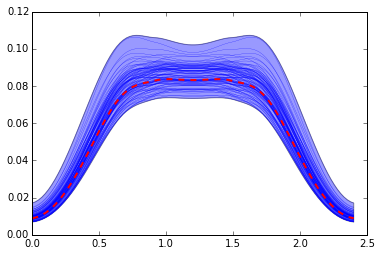

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

time = monte_carlo_results['Abscissa.t'][0]
plt.fill_between(time, max_muscle_activity.min(0), max_muscle_activity.max(0),alpha=0.4  )
for trace in max_muscle_activity:
    plt.plot(time, trace,'b', lw=0.2 )
# Plot result with the mean of the inputs ( stored in the first run)
plt.plot(time, max_muscle_activity[0],'r--', lw = 2, ) 


## Latin Hypercube sampling

Monte Carlo studies are not very efficient when investigating the effect of many parameters. It quickly becomes necessary to run the model thousands of times. Not very convenient if the AnyBody model takes a long time to run. 

Another approach is to use Latin Hypercube sampling. From Wikipedia
> Latin hypercube sampling (LHS) is a statistical method for generating a sample of plausible collections of parameter values from a multidimensional distribution. The sampling method is often used to construct computer experiments.

Using LHS we can generate a sample that better spans the whole multidimensional space. Thus, fever model evaluations are necessary. See [pyDOE](http://pythonhosted.org/pyDOE/randomized.html) for examples (and explanation of the `criterion`/`iterations` parameters which can be parsed to `create_macros_LHS()`).

To following uses LHS to do the same as in the previous example:

In [13]:
patella_tendon_insertion = distributions.norm([0.02, 0.12, 0], [0.01,0.01,0.01]) 
patella_tendon_origin = distributions.norm([0.0,-0.03, 0], [0.01,0.01,0.01]) 

macro = [ mc.Load('Knee.any'),
          mc.SetValue_random('Main.MyModel.Tibia.Patella2.sRel', patella_tendon_insertion ) ,
          mc.SetValue_random('Main.MyModel.Patella.Lig.sRel', patella_tendon_origin ) ,
          mc.OperationRun('Main.MyStudy.InverseDynamics'),
          mc.Dump('Main.MyStudy.Output.Abscissa.t'),
          mc.Dump('Main.MyStudy.Output.MaxMuscleActivity')
        ]
mg = AnyMacro(macro, seed=1)
LHS_macros = mg.create_macros_LHS(25)

In [14]:
from anypytools.abcutils import AnyPyProcess 

app = AnyPyProcess()
lhs_results = app.start_macro(LHS_macros)

[****************100%******************]  25 of 25 complete

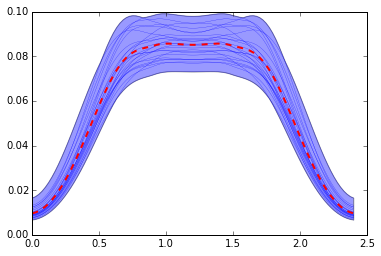

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

time = lhs_results['Abscissa.t'][0]
plt.fill_between(time, lhs_results['MaxMus'].min(0), lhs_results['MaxMus'].max(0),alpha=0.4  )
for trace in lhs_results['MaxMus']:
    plt.plot(time, trace,'b', lw=0.2 )
# Plot the mean value that was stored in the first results
plt.plot(time, lhs_results['MaxMus'].mean(0),'r--', lw = 2, ) 
